In [321]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier

plt.style.use('default')

trainData = pd.read_csv('input/train.csv')
testData = pd.read_csv('input/test.csv')

| Variável | Definição | Valores |
|---|---|---|
| Pclass | Classe do Bilhete | 1 \| 2 \| 3 |
| Sex | Sexo | "male" \| "female" |
| Age | Idade | Anos (fracional se menor que 1)|
| Sibsp | Qtd de irmãos/conjugues a bordo |  |
| Parch | Qtd de pais/filhos a bordo |  |
| Ticket | Numero do Ticket |  |
| Fare | Taxa de passagem |  |
| Cabin | Numero da Cabine |  |
| Embarked | Porto de Embarque | C = Cherbourg, Q = Queenstown, S = Southampton |

Consideramos que alguns campos como o número da cabine, o ticket, e o nome não são relevantes para a previsão e por isso removemos eles

In [322]:
testPassengers = testData["PassengerId"]
trainData = trainData.drop(["Cabin","Ticket","Name","PassengerId"], axis=1)
testData = testData.drop(["Cabin","Ticket","Name","PassengerId"], axis=1)


In [323]:
f"qtd de idades inválidas: {trainData['Age'].isna().sum()}"

'qtd de idades inválidas: 177'

Também percebemos que o campo `Age` possui alguns valores inválidos, sem idade informada ou com NaNs. Porém consideramos Idade uma informação relevante para a previsão. Então precisamos tratar esses dados!

'qtd de idades inválidas: 0'

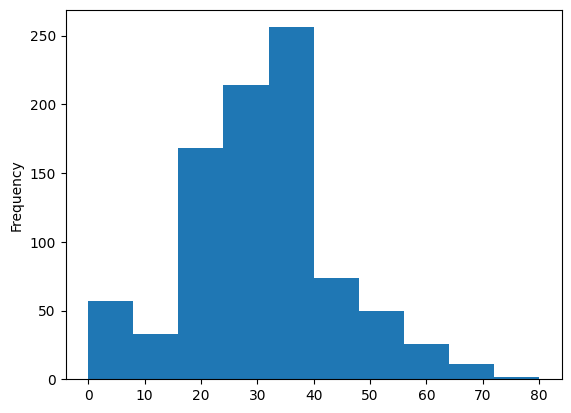

In [324]:
columns = ["SibSp", "Parch", "Age"]
imputer = IterativeImputer(min_value = 0)

imputedValues = imputer.fit_transform(trainData[columns])
correctedValues = pd.DataFrame(imputedValues, columns=columns)
trainData["Age"] = correctedValues["Age"]

imputedValues = imputer.fit_transform(trainData[columns])
correctedValues = pd.DataFrame(imputedValues, columns=columns)
testData["Age"] = correctedValues["Age"]

trainData["Age"].plot(kind='hist')
f"qtd de idades inválidas: {trainData['Age'].isna().sum()}"

Usamos o `InterativeImputer` do `Scikit`, que basicamente tenta aproximar o valor que está faltando na coluna idade à partir das outras 2 colunas, iterando recursivamente até chegar em um valor que talvez seja próximo do valor real, podemos parametrizar ele mais, mas deixamos no comportamento padrão.  
> Existem outros métodos de se imputar valores como o `SimpleImputer`, ou simplesmente tentar fazer uma média, moda ou mediana para preencher os valores que estão faltando. Mas no nosso caso o InterativeImputer funcionou bem.

In [325]:
#Valores faltando na taxa de embarque => média
trainData["Fare"] = trainData["Fare"].replace(np.NaN, trainData["Fare"].mean())
testData["Fare"] = testData["Fare"].replace(np.NaN, testData["Fare"].mean())

#converter em valores numéricos
trainData["Sex"] = trainData["Sex"].map({"male": 0, "female": 1})
trainData["Embarked"] = trainData["Embarked"].map({"C": 0, "Q": 1, "S": 2})
testData["Sex"] = testData["Sex"].map({"male": 0, "female": 1})
testData["Embarked"] = testData["Embarked"].map({"C": 0, "Q": 1, "S": 2})

#Criamos essa coluna temporaria "FamilyCount" somando a qtd de filhos e de conjugues ao passageiro
#O dado mais relevante é saber se o passageiro está sozinho ou não.
trainData["FamilyCount"] = trainData['SibSp'] + trainData['Parch'] + 1
testData["FamilyCount"] = testData['SibSp'] + testData['Parch'] + 1
trainData['IsAlone'] = trainData["FamilyCount"] == 1
testData['IsAlone'] = trainData["FamilyCount"] == 1

trainData = trainData.drop(["SibSp","Parch", "FamilyCount"], axis=1)
testData = testData.drop(["SibSp","Parch", "FamilyCount"], axis=1)

#removo qualquer NaN remanescente.
trainData = trainData.dropna().reset_index(drop=True)
testData = testData.dropna().reset_index(drop=True)



In [326]:
matriz = trainData.corr()
corrSurvived = abs(matriz["Survived"])
print(f"Valores não relacionados:\n{corrSurvived[corrSurvived < 0.1]}")


Valores não relacionados:
Age    0.066552
Name: Survived, dtype: float64


Mesmo com os tratamentos o AGE ainda não tá correlacionado à taxa de sobrevivencia nos dados de treino.

# Treinando MLP

In [327]:
trainY = trainData["Survived"]
trainX = trainData.drop(["Survived"], axis=1)

mlp = MLPClassifier(
  hidden_layer_sizes=256,
  activation='logistic',
  learning_rate_init=.01,
  solver='sgd',
  max_iter=10000,
  tol=1e-4
)
mlp.fit(trainX, trainY)

# Scoring
print("Training set score: {:.4f}".format(mlp.score(trainX, trainY)))


# Confusion matrix
y_pred = mlp.predict(testData)
result = pd.DataFrame({"PassengerId" : testPassengers, "Survived": y_pred})

result["Survived"].map({1: "yes", 0: "no"}).value_counts()
# fig, ax = plt.subplots()

Training set score: 0.7537


Survived
yes    225
no     193
Name: count, dtype: int64